In [1]:
# %pip install matplotlib --quiet

## Purpose

---

This file is to automagically calculate outputs so we can validate the system output.

Using many points.


In [2]:
from loguru import logger
logger.remove()

In [3]:
from gps_coordinate import GPSPoint
from math import sqrt, atan2
import numpy as np

Made using [mapcustomizer](https://www.mapcustomizer.com/#)

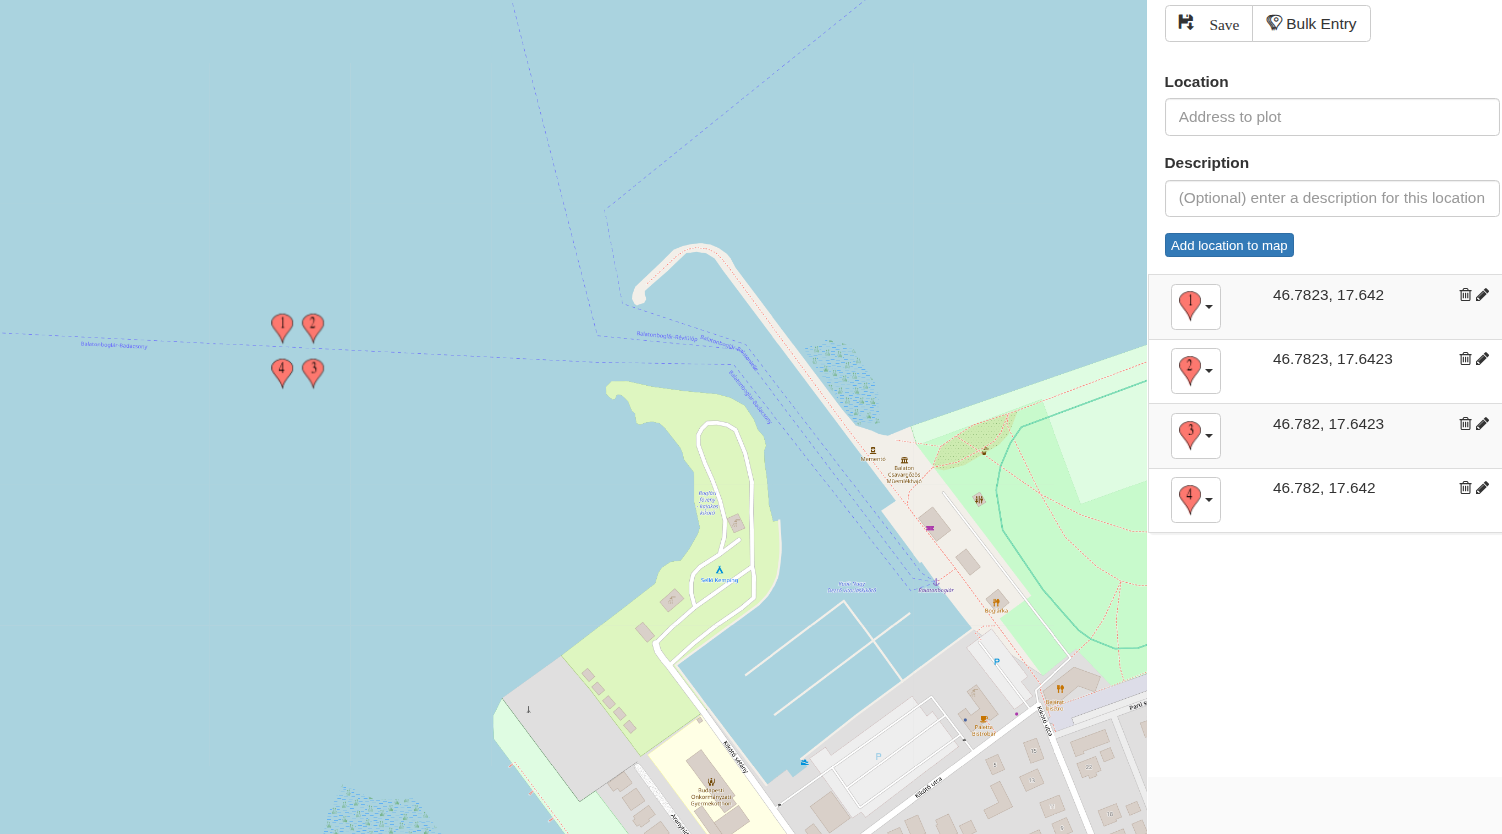


In [4]:
# Rectangle corners (latitude, longitude)
W, E = 17.6420, 17.6423
S, N = 46.7820, 46.7823

corner_1 = GPSPoint(N, W)  # bottom-left
corner_2 = GPSPoint(N, E)  # bottom-right
corner_3 = GPSPoint(S, E)  # top-right
corner_4 = GPSPoint(S, W)  # top-left

# Ordered loop of waypoints
waypoints = [corner_1, corner_2, corner_3, corner_4, corner_1]
waypoints

[GPSPoint(lat=46.7823, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.642)]

In [5]:
# Controller constants

k1, k2, k3, k4 = 1.6, 19.92, 2.125, 92.1
U = 1.1  # m/s
DT = 1.0  # timestep in seconds
engine_rpm = 440

In [6]:
# Start state
boat = GPSPoint(N, W)  # start at corner_1
psi_boat = np.deg2rad(-45)  # in radians
psi_boat

np.float64(-0.7853981633974483)

In [7]:
def heading_to_next_waypoint(x0, y0, x1, y1):
    """Eq. (4): Heading from point 0 to point 1"""
    return atan2(y1 - y0, x1 - x0)


def cross_track_error(x, y, x_ref, y_ref, psi_k):
    return (x - x_ref) * np.sin(psi_k) - (y - y_ref) * np.cos(psi_k)


def control_output(e_psi, de_psi, e_y, int_e_y):
    delta_PD = k1 * e_psi + k2 * de_psi
    delta_PI = k3 * e_y + k4 * int_e_y
    return delta_PD + delta_PI


def normalize_angle(angle_rad):
    return np.arctan2(np.sin(angle_rad), np.cos(angle_rad))


def distance_m(p1: GPSPoint, p2: GPSPoint):
    # L2 = sqrt((p2.Xn - p1.Xn)**2 + (p2.Yn - p1.Yn)**2)
    dist = p1.haversine_distance(p2)
    # print(f"L2: {L2:.3} | HS: {dist:.3} | Diff: {abs(L2 - dist):.3}")
    return dist

In [8]:
waypoints

[GPSPoint(lat=46.7823, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.6423),
 GPSPoint(lat=46.782, lon=17.642),
 GPSPoint(lat=46.7823, lon=17.642)]

In [9]:
for wp in waypoints:
    print(distance_m(boat, wp))

0.0
22.84296065357419
40.43008549469783
33.35847799370506
0.0


In [10]:
WAYPOINT_RADIUS = 10  # meters

In [11]:
last_e_psi = 0.0
int_e_y = 0.0
steps = 0
waypoint_index = 0
visited = 0

positions = []

MAX_STEPS = 10_000

while visited < len(waypoints) - 1 and steps < MAX_STEPS:

    wp_start = waypoints[waypoint_index]
    wp_end = waypoints[waypoint_index + 1]

    # Desired path heading
    psi_k = heading_to_next_waypoint(
        wp_start.Xn, wp_start.Yn,
        wp_end.Xn, wp_end.Yn
    )

    # Errors
    e_psi = normalize_angle(psi_boat - psi_k)
    de_psi = (e_psi - last_e_psi) / DT
    last_e_psi = e_psi

    e_y = cross_track_error(boat.Xn, boat.Yn, wp_start.Xn, wp_start.Yn, psi_k)
    int_e_y += e_y * DT

    # Rudder control
    rudder_cmd_deg = control_output(e_psi, de_psi, e_y, int_e_y)
    rudder_cmd_clip = np.clip(rudder_cmd_deg, -35, 35)  # deg

    # Anti-windup: don't let int_e_y grow if saturated
    if abs(rudder_cmd_deg - rudder_cmd_clip) > 1e-2:
        # print(f"abs(rudder_cmd_deg - rudder_cmd_clip) = {abs(rudder_cmd_deg - rudder_cmd_clip)} > 1e-2")
        int_e_y -= e_y * DT

    # Integrate heading
    psi_boat += np.deg2rad(rudder_cmd_clip) * DT
    psi_boat = normalize_angle(psi_boat)

    # Move boat
    dx = np.cos(psi_boat) * WAYPOINT_RADIUS / 3  # U * np.cos(psi_boat) * DT
    dy = np.sin(psi_boat) * WAYPOINT_RADIUS / 3  # U * np.sin(psi_boat) * DT

    print(f"Change: {dx, dy}")

    boat.set_from_Xn_Yn(boat.Xn + dx, boat.Yn + dy)
    positions.append((boat.latitude, boat.longitude))

    # Waypoint switch
    dist = distance_m(boat, wp_end)
    if dist < WAYPOINT_RADIUS:
        print("fak")
        waypoint_index += 1
        visited += 1
        int_e_y = 0.0
        last_e_psi = 0.0

    if steps % 1 == 0:
        print(f"Step {steps}:")
        print(f"cross_track_error: {e_y:.3f} | Heading error: {e_psi:.3f}")
        print(f"rudder_cmd: {rudder_cmd_deg:.3f} | clipped: {rudder_cmd_clip:.3f}")
        print(f"[{visited}] → WP{waypoint_index+1}: {dist:.2f} m | rudder: {rudder_cmd_clip:.2f}° | ψ: {np.rad2deg(psi_boat):.2f}°")
        print()

    steps += 1

if len(waypoints) - 1 == visited:
    print("Simulation completed: All waypoints reached.")
else:
    print("Nope :|")

Change: (np.float64(1.532696822302288), np.float64(-2.9600593848799015))
Step 0:
cross_track_error: 0.000 | Heading error: -0.819
rudder_cmd: -17.625 | clipped: -17.625
[0] → WP1: 21.63 m | rudder: -17.63° | ψ: -62.63°

Change: (np.float64(2.9533320486310437), np.float64(-1.5456199149984682))
Step 1:
cross_track_error: 3.010 | Heading error: -1.127
rudder_cmd: 275.678 | clipped: 35.000
[0] → WP1: 19.10 m | rudder: 35.00° | ψ: -27.63°

Change: (np.float64(3.305759147898344), np.float64(0.4278639587503556))
Step 2:
cross_track_error: 4.654 | Heading error: -0.516
rudder_cmd: 449.858 | clipped: 35.000
[0] → WP1: 15.82 m | rudder: 35.00° | ψ: 7.37°

Change: (np.float64(2.462506679224884), np.float64(2.2465911879743374))
Step 3:
cross_track_error: 4.337 | Heading error: 0.095
rudder_cmd: 421.012 | clipped: 35.000
[0] → WP1: 12.87 m | rudder: 35.00° | ψ: 42.37°

Change: (np.float64(0.7285756128263768), np.float64(3.252735569871271))
Step 4:
cross_track_error: 2.175 | Heading error: 0.706
rud

---


In [12]:
x_min = min(positions, key=lambda k: k[0])
y_min = min(positions, key=lambda k: k[1])

x_max = max(positions, key=lambda k: k[0])
y_max = max(positions, key=lambda k: k[1])

x_min, y_min, x_max, y_max

((46.782258139926654, 17.642056723135784),
 (46.78227292712653, 17.642018754848575),
 (46.78240518645371, 17.642118653080658),
 (46.78235358115154, 17.642188581538306))

In [13]:
GPSPoint(46.782126684841636, 17.64197758416895).Xn

701668.5392764601